### Pyspark - Machine Learning

Jay Urbain, PhD   
4/30/2023


![](spark-cluster-overview.webp)

# Predicting House Prices with Apache Spark

## LINEAR REGRESSION

In this lab will apply linear regression to the [California Housing](http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html) data set to predict house prices using Apache Spark.

*Note: This is actually 'small' data and that using Spark in this context is a bit overkill, but transferable to very large datasets.*

Submission instructions: Complete all **TODO** items. Submit your copy of this notebook along with feedback on the lab to Canvas.

## 1. The Data Set

The California Housing data set appeared in a 1997 paper titled *Sparse Spatial Autoregressions*, written by Pace, R. Kelley and Ronald Barry and published in the Statistics and Probability Letters journal. The researchers built this data set by using the 1990 California census data. Wouldn't you like to buy a house in California for 1990's prices?

The data contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). In this sample a block group on average includes 1425.5 individuals living in a geographically compact area.

This spatial data contain 20,640 observations on housing prices with 9 economic variables:

<p style="text-align: justify;"></p>
<pre><strong>Longitude: </strong>refers to the angular distance of a geographic place north or south of the earth’s equator for each block group
<strong>Latitude: </strong>refers to the angular distance of a geographic place east or west of the earth’s equator for each block group
<strong>Housing Median Age: </strong>is the median age of the people that belong to a block group. Note that the median is the value that lies at the midpoint of a frequency distribution of observed values
<strong>Total Rooms: </strong>is the total number of rooms in the houses per block group
<strong>Total Bedrooms: </strong>is the total number of bedrooms in the houses per block group
<strong>Population: </strong>is the number of inhabitants of a block group
<strong>Households: </strong>refers to units of houses and their occupants per block group
<strong>Median Income: </strong>is used to register the median income of people that belong to a block group
<strong>Median House Value: </strong>is the dependent variable and refers to the median house value per block group
</pre>

The Median house value is the dependent variable and will be assigned the role of the target variable that we are trying to predict in our ML model.


Make sure Spark can find Java. Set JAVA_HOME to Java in *your* environment path.

In [1]:
import os

JAVA_HOME = "C:\Program Files\Java\jdk-17.0.1"
os.environ["JAVA_HOME"] = JAVA_HOME

Imports

In [2]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

Set up visualization 

In [4]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Set a random seed for notebook reproducability

In [5]:
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

## 2. Create the Spark Session

Sets the Spark master URL to connect to, such as “local” to run locally, “local[2]” to run locally with 2 cores.

In [6]:
spark = SparkSession.builder.master("local[2]").appName("Linear-Regression-California-Housing").getOrCreate()

In [7]:
sc = spark.sparkContext
sc

<SparkContext master=local[2] appName=Linear-Regression-California-Housing>

SQLContext is a class in Apache Spark that provides a programming interface to work with structured and semi-structured data using SQL 

It's based on dataframes.

In [8]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

C:\Users\czerkisi\AppData\Roaming\Python\Python310\site-packages\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## 3. Load The Data From a File Into a Dataframe

Download the California housung dataset:

https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

Set the path to the housing data.

In [9]:
HOUSING_DATA = 'CaliforniaHousing/cal_housing.data'

Specifying the schema when loading data into a DataFrame will give better performance than using schema inference.

Note: this is what we did in the medical dataset demoed in class.

In [10]:
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)

Load the data

Spark cache is a mechanism that saves a DataFrame (/RDD/Dataset) in the Executors memory or disk. This enables the DataFrame to be calculated only once and reused for subsequent transformations and actions. 

In [11]:
housing_df = spark.read.csv(path=HOUSING_DATA, schema=schema).cache()

Inspect the first 5 rows

take() and show() are different. show() prints results, take() returns a list of rows (in PySpark) and can be used to create a new dataframe. They are both actions.

In [12]:
# Using take

housing_df.take(5)

[Row(long=-122.2300033569336, lat=37.880001068115234, medage=41.0, totrooms=880.0, totbdrms=129.0, pop=322.0, houshlds=126.0, medinc=8.325200080871582, medhv=452600.0),
 Row(long=-122.22000122070312, lat=37.86000061035156, medage=21.0, totrooms=7099.0, totbdrms=1106.0, pop=2401.0, houshlds=1138.0, medinc=8.301400184631348, medhv=358500.0),
 Row(long=-122.23999786376953, lat=37.849998474121094, medage=52.0, totrooms=1467.0, totbdrms=190.0, pop=496.0, houshlds=177.0, medinc=7.257400035858154, medhv=352100.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1274.0, totbdrms=235.0, pop=558.0, houshlds=219.0, medinc=5.643099784851074, medhv=341300.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1627.0, totbdrms=280.0, pop=565.0, houshlds=259.0, medinc=3.8461999893188477, medhv=342200.0)]

In [13]:
# Using show

housing_df.show(5)

+-------+-----+------+--------+--------+------+--------+------+--------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|   medhv|
+-------+-----+------+--------+--------+------+--------+------+--------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|452600.0|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|358500.0|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|352100.0|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|341300.0|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|342200.0|
+-------+-----+------+--------+--------+------+--------+------+--------+
only showing top 5 rows



**TODO**: Show the dataframe columns

In [14]:
# TODO: show the dataframe columns

housing_df.columns

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

**TODO**: Show the schema of the dataframe

In [15]:
# TODO show the schema of the dataframe

housing_df.printSchema()

root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- medage: float (nullable = true)
 |-- totrooms: float (nullable = true)
 |-- totbdrms: float (nullable = true)
 |-- pop: float (nullable = true)
 |-- houshlds: float (nullable = true)
 |-- medinc: float (nullable = true)
 |-- medhv: float (nullable = true)



## 4. Data Exploration

In [16]:
# run a sample query using dataframe select

housing_df.select('pop','totbdrms').show(10)

+------+--------+
|   pop|totbdrms|
+------+--------+
| 322.0|   129.0|
|2401.0|  1106.0|
| 496.0|   190.0|
| 558.0|   235.0|
| 565.0|   280.0|
| 413.0|   213.0|
|1094.0|   489.0|
|1157.0|   687.0|
|1206.0|   665.0|
|1551.0|   707.0|
+------+--------+
only showing top 10 rows



In order to use SQL, first, create a temporary table on the DataFrame using `createOrReplaceTempView()` function. 

Once created, this table can be accessed throughout the SparkSession using `sql()` and it will be dropped 
along with your SparkContext upon termination.

Use `sql()` method of the `SparkSession` object to run the query and this method returns a new DataFrame.

In [17]:
housing_df.createOrReplaceTempView("HOUSING")

housing_df_sql = spark.sql("SELECT pop, totbdrms from HOUSING")
housing_df_sql.printSchema()

root
 |-- pop: float (nullable = true)
 |-- totbdrms: float (nullable = true)



### 4.1 Distribution of the median age of the people living in the area:

**TODO**: Write a query to generate a histogram of the median age for people living in the area.

The query results should look something like the following.

```
result_df.show(10)

+------+--------+
|medage|count(1)|
+------+--------+
|  52.0|    1273|
|  36.0|     862|
|  35.0|     824|
|  16.0|     771|
|  17.0|     698|
|  34.0|     689|
|  26.0|     619|
|  33.0|     615|
|  18.0|     570|
|  25.0|     566|
+------+--------+
only showing top 10 rows
```

In [20]:
# TODO group by housing median age and see the distribution
# your work here:

result_df = spark.sql("SELECT medage, COUNT(*) FROM HOUSING GROUP BY medage;")

In [21]:
result_df.show(10)

+------+--------+
|medage|count(1)|
+------+--------+
|  18.0|     570|
|  47.0|     198|
|   9.0|     205|
|  39.0|     369|
|   5.0|     244|
|  17.0|     698|
|  30.0|     476|
|  26.0|     619|
|  41.0|     296|
|  29.0|     461|
+------+--------+
only showing top 10 rows



Plot the result

<Axes: xlabel='medage'>

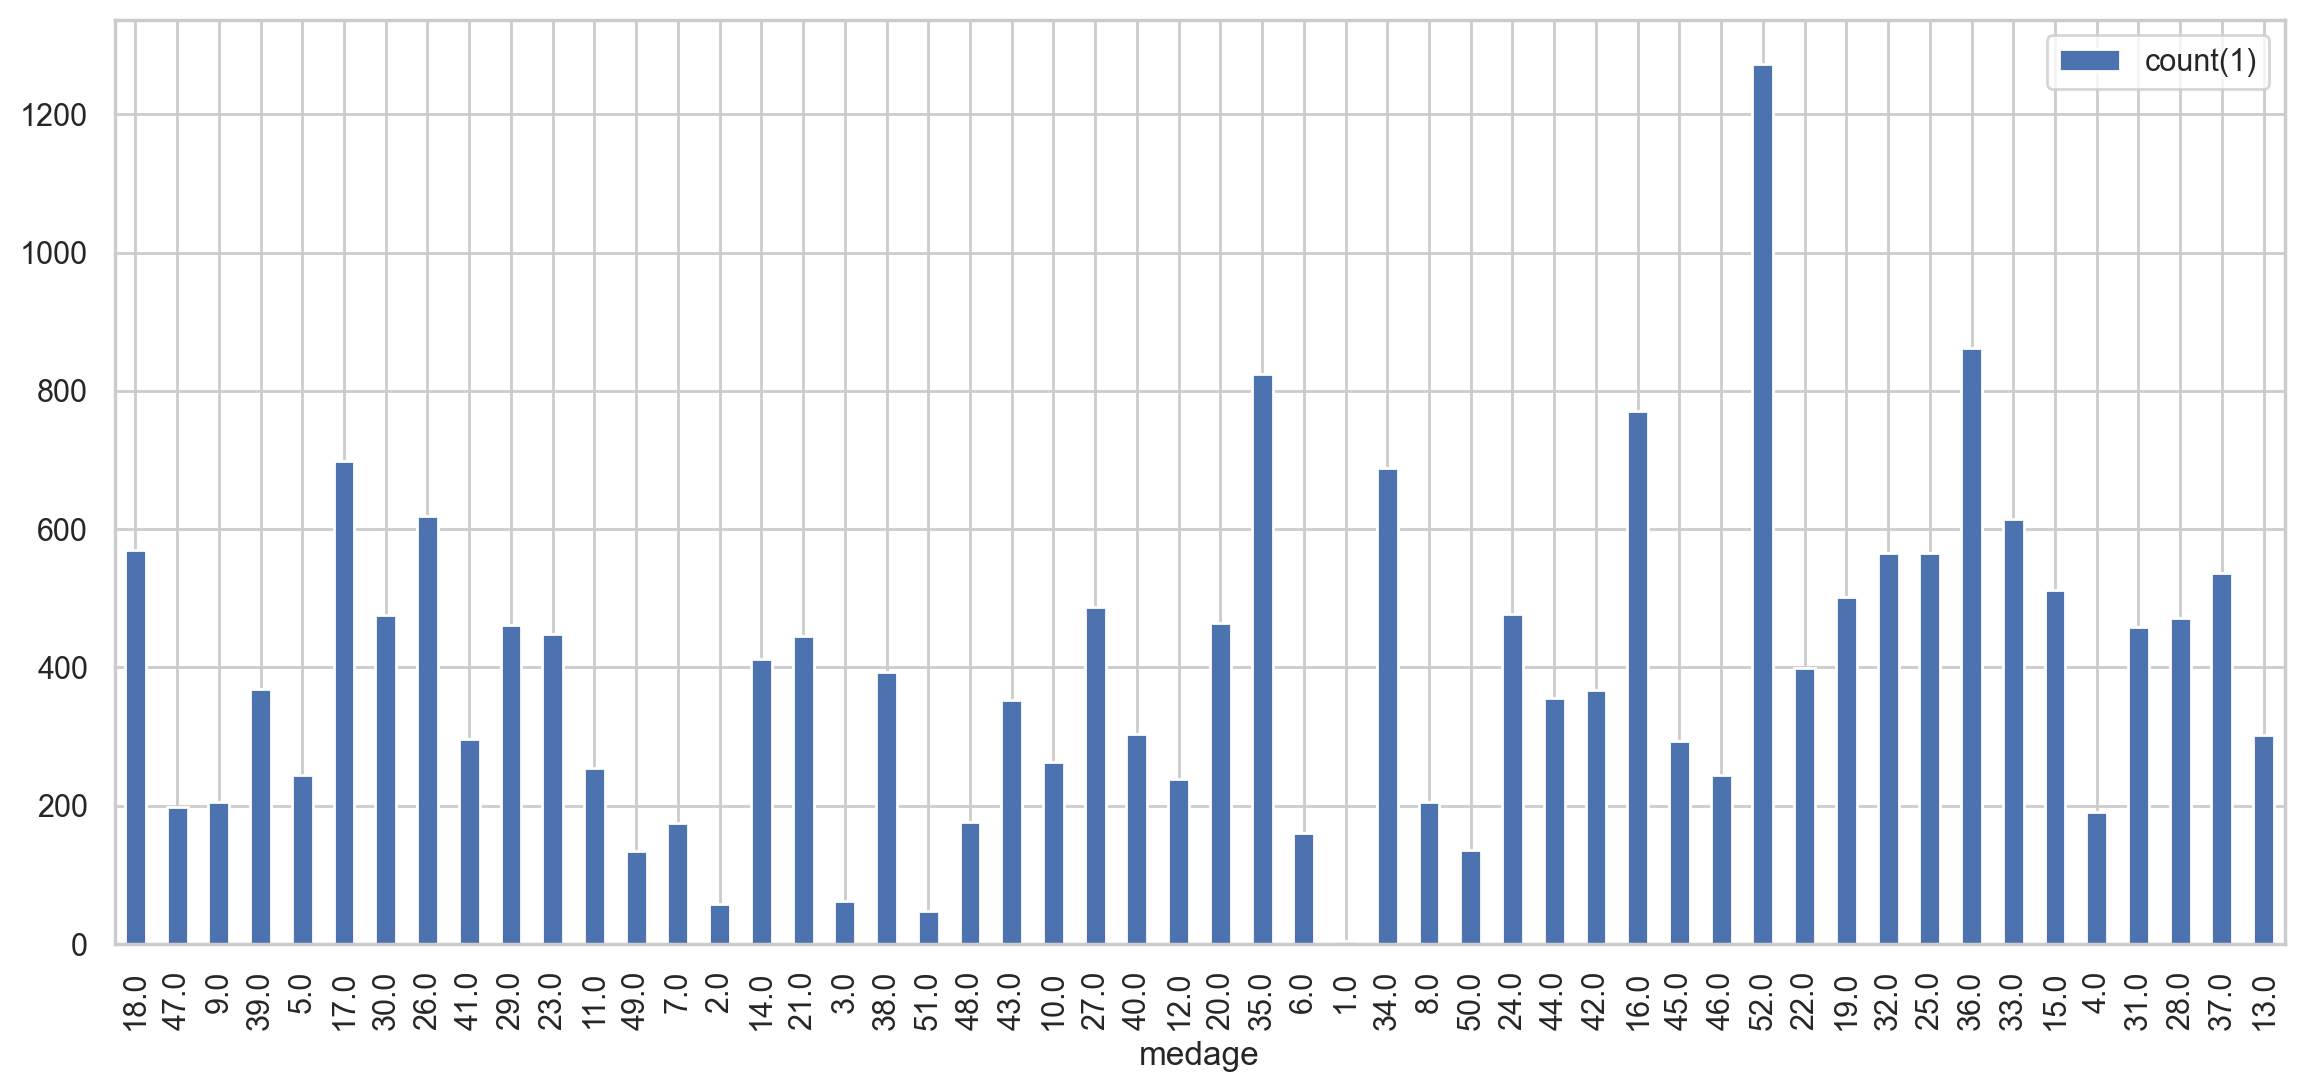

In [22]:
result_df.toPandas().plot.bar(x='medage',figsize=(14, 6))

### 4.2 Summary Statistics

In Spark you can use `df.describe()` or `df.summary()` to review statistical information for numerical columns.

The difference is that `df.summary()` returns the same information as `df.describe()` plus quartile information (25%, 50% and 75%).

In [23]:
(housing_df.describe().select(
                    "summary",
                    F.round("medage", 4).alias("medage"),
                    F.round("totrooms", 4).alias("totrooms"),
                    F.round("totbdrms", 4).alias("totbdrms"),
                    F.round("pop", 4).alias("pop"),
                    F.round("houshlds", 4).alias("houshlds"),
                    F.round("medinc", 4).alias("medinc"),
                    F.round("medhv", 4).alias("medhv"))
                    .show())

+-------+-------+---------+--------+---------+--------+-------+-----------+
|summary| medage| totrooms|totbdrms|      pop|houshlds| medinc|      medhv|
+-------+-------+---------+--------+---------+--------+-------+-----------+
|  count|20640.0|  20640.0| 20640.0|  20640.0| 20640.0|20640.0|    20640.0|
|   mean|28.6395|2635.7631| 537.898|1425.4767|499.5397| 3.8707|206855.8169|
| stddev|12.5856|2181.6153|421.2479|1132.4621|382.3298| 1.8998|115395.6159|
|    min|    1.0|      2.0|     1.0|      3.0|     1.0| 0.4999|    14999.0|
|    max|   52.0|  39320.0|  6445.0|  35682.0|  6082.0|15.0001|   500001.0|
+-------+-------+---------+--------+---------+--------+-------+-----------+



In [24]:
(housing_df.summary().select(
                    "summary",
                    F.round("medage", 4).alias("medage"),
                    F.round("totrooms", 4).alias("totrooms"),
                    F.round("totbdrms", 4).alias("totbdrms"),
                    F.round("pop", 4).alias("pop"),
                    F.round("houshlds", 4).alias("houshlds"),
                    F.round("medinc", 4).alias("medinc"),
                    F.round("medhv", 4).alias("medhv"))
                    .show())

+-------+-------+---------+--------+---------+--------+-------+-----------+
|summary| medage| totrooms|totbdrms|      pop|houshlds| medinc|      medhv|
+-------+-------+---------+--------+---------+--------+-------+-----------+
|  count|20640.0|  20640.0| 20640.0|  20640.0| 20640.0|20640.0|    20640.0|
|   mean|28.6395|2635.7631| 537.898|1425.4767|499.5397| 3.8707|206855.8169|
| stddev|12.5856|2181.6153|421.2479|1132.4621|382.3298| 1.8998|115395.6159|
|    min|    1.0|      2.0|     1.0|      3.0|     1.0| 0.4999|    14999.0|
|    25%|   18.0|   1447.0|   295.0|    787.0|   280.0| 2.5625|   119600.0|
|    50%|   29.0|   2127.0|   435.0|   1166.0|   409.0| 3.5347|   179700.0|
|    75%|   37.0|   3146.0|   647.0|   1724.0|   605.0| 4.7426|   264700.0|
|    max|   52.0|  39320.0|  6445.0|  35682.0|  6082.0|15.0001|   500001.0|
+-------+-------+---------+--------+---------+--------+-------+-----------+



Notice that multiple attributes have a wide range of values. We will need to normalize the dataset.

## 5. Data Preprocessing

+ We shouldn't need to care about missing values; all zero values have been excluded from the data set.
+ We should definitely standardize our data, as we have seen that the range of minimum and maximum values is quite big.
+ There are possibly some additional attributes that we could add, such as a feature that registers the number of bedrooms per room or the rooms per household.
+ Our dependent variable is also quite large. To make our life easier, we'll have to adjust the values.


### 5.1 Preprocessing The Target Values

`medianHouseValue` is our dependent variable (target). To make things a little easier we will express the house values in units of 100,000. That means that a target such as `452600.000000` should become `4.526`:

In [25]:
# Adjust the values of median house value
housing_df = housing_df.withColumn("medhv", col("medhv")/100000)

In [26]:
# Show the first 2 lines of `df`
housing_df.show(2)

+-------+-----+------+--------+--------+------+--------+------+-----+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|
+-------+-----+------+--------+--------+------+--------+------+-----+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|
+-------+-----+------+--------+--------+------+--------+------+-----+
only showing top 2 rows



We can  see that the values have been adjusted correctly when we look at the result of the `show()` method:

## 6. Feature Engineering

Now that we have adjusted the values for `medhv`, we will add the following columns to the data set:

+ Rooms per household which refers to the number of rooms in households per block group. `totrooms/houshlds`
+ Population per household, which basically gives us an indication of how many people live in households per block group. `pop/houshlds`
+ Bedrooms per total rooms which will give us an idea about how many rooms are bedrooms per block group. `totbdrms/totrooms`

We can add columns to a DataFrame based on another existing column value using `df.withColumn`

https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.sql.DataFrame.withColumn.html


The results should look as follows:

```
+--------+--------+----+
|rmsperhh|rmsperhh|  as|
+--------+--------+----+
|    6.98|    2.56|0.15|
|    6.24|    2.11|0.16|
|    8.29|     2.8|0.13|
|    5.82|    2.55|0.18|
|    6.28|    2.18|0.17|
+--------+--------+----+
only showing top 5 rows
```

In [27]:
housing_df.columns

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

In [28]:
# Add the new columns to `df`
housing_df = (housing_df.withColumn("rmsperhh", F.round(col("totrooms")/col("houshlds"), 2))
                       .withColumn("popperhh", F.round(col("pop")/col("houshlds"), 2))
                       .withColumn("bdrmsperrm", F.round(col("totbdrms")/col("totrooms"), 2)))

In [29]:
# Inspect the result
housing_df.show(5)

+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|rmsperhh|popperhh|bdrmsperrm|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|    6.98|    2.56|      0.15|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|    6.24|    2.11|      0.16|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|3.521|    8.29|     2.8|      0.13|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|3.413|    5.82|    2.55|      0.18|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|3.422|    6.28|    2.18|      0.17|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
only showing top 5 rows



Looking at the first row, there are about 6.98 rooms per household, the households in the block group consist of about 2.6 people and the amount of bedrooms is quite low with 0.15:

Since we don't want to  standardize our target values, we need to isolate the target value in our data set. 

Note: this is also the time to leave out variables that we might not want to consider in our analysis. Let's leave out variables such as longitude, latitude, housingMedianAge and totalRooms.

In this case, we will use the `select()` method and pass the column names in an order that is more appropriate. In this case, the target variable medianHouseValue is put first, so that it won't be affected by the standardization.

**TODO**: Select and order the columns in the dataframe as follows:

```
"medhv", 
"totbdrms", 
"pop", 
"houshlds", 
"medinc", 
"rmsperhh", 
"popperhh", 
"bdrmsperrm"
```

In [30]:
# TODO: Re-order and select columns

housing_df_select = housing_df.select("medhv", "totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm")
housing_df_select.columns

['medhv',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'rmsperhh',
 'popperhh',
 'bdrmsperrm']

### 6.1 Feature Extraction

Now that we have re-ordered the data, we're ready to normalize the data. Choose the features to be normalized.

In [31]:
featureCols = ["totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm"]

Use a VectorAssembler to put features into a feature vector column.

https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.ml.feature.VectorAssembler.html

In [32]:
# put features into a feature vector column
assembler = VectorAssembler(inputCols=featureCols, outputCol="features") 

In [33]:
assembled_df = assembler.transform(housing_df_select)

In [34]:
assembled_df.show(10, truncate=False)

+-----+--------+------+--------+------+--------+--------+----------+-------------------------------------------------------+
|medhv|totbdrms|pop   |houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|features                                               |
+-----+--------+------+--------+------+--------+--------+----------+-------------------------------------------------------+
|4.526|129.0   |322.0 |126.0   |8.3252|6.98    |2.56    |0.15      |[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |
|3.585|1106.0  |2401.0|1138.0  |8.3014|6.24    |2.11    |0.16      |[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|
|3.521|190.0   |496.0 |177.0   |7.2574|8.29    |2.8     |0.13      |[190.0,496.0,177.0,7.257400035858154,8.29,2.8,0.13]    |
|3.413|235.0   |558.0 |219.0   |5.6431|5.82    |2.55    |0.18      |[235.0,558.0,219.0,5.643099784851074,5.82,2.55,0.18]   |
|3.422|280.0   |565.0 |259.0   |3.8462|6.28    |2.18    |0.17      |[280.0,565.0,259.0,3.8461999893188477,6.28,2.18,0.17]  |


All of the features should have been transformed into a Dense Vector. Notice the features column above.

### 6.2 Standardization

We can now scale the data using `StandardScaler`. The input columns are the `features`, and the output column are rescaled features that we will be include in the `scaled_df` named `"features_scaled"`:

In [35]:
# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

In [36]:
# Fit the DataFrame to the scaler
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)

In [37]:
# Inspect the result
scaled_df.select("features", "features_scaled").show(10, truncate=False)

+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|features                                               |features_scaled                                                                                                                       |
+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |[0.30623297630686513,0.2843362208866199,0.3295584480852433,4.38209543579743,2.8211223886115664,0.24648542140099877,2.5828740130262697]|
|[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|[2.6255323394991694,2.1201592122632746,2.9764882057222772,4.36956799913841,2.522034914747303,0.20315790592035446,2.755065613894688]   |
|[190.0,496.0,177.0,7.2574000358581

### 7. Building A Machine Learning Model With Spark ML

With preprocessing done, we can finally build the Linear Regression model. 

First, split the data into training and test sets using `randomSplit()`:

Pass in a list with two numbers that represent the size that we want your training and test sets to have and a seed, which is needed for reproducibility reasons.

https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.sql.DataFrame.randomSplit.html

In [38]:
# Split the data into train and test sets
train_data, test_data = scaled_df.randomSplit([.8,.2], seed=rnd_seed)

In [39]:
train_data.columns

['medhv',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'rmsperhh',
 'popperhh',
 'bdrmsperrm',
 'features',
 'features_scaled']

**Create an ElasticNet model:**

`ElasticNet` is a linear regression model trained with `L1` and `L2` prior as a regularizer. This combination allows for learning a sparse model where few of the weights are non-zero like `Lasso`, while still maintaining the regularization properties of `Ridge` regression. We can control the convex combination of `L1` and `L2` using the `l1_ratio parameter`.

Elastic-net is useful when there are multiple features which are correlated with one another. Lasso is likely to pick one of these at random, while elastic-net is likely to pick both.

A practical advantage of trading-off between Lasso and Ridge is it allows Elastic-Net to inherit some of Ridge’s stability under rotation.

The objective function to minimize is in this case:
\begin{align}
min_w\frac{1}{2n_{samples}}{\parallel{X_w - y}\parallel}^2_2 + \alpha\lambda{\parallel{X_w - y}\parallel}_1 + \frac{\alpha(1-\lambda)}{2}{\parallel{w}\parallel}^2_2
\end{align}

http://scikit-learn.org/stable/modules/linear_model.html#elastic-net

In [40]:
# Initialize `lr`
lr = (LinearRegression(featuresCol='features_scaled', labelCol="medhv", predictionCol='predmedhv', 
                               maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=False))

In [41]:
# Fit the data to the model
linearModel = lr.fit(train_data)

## 8. Evaluating the Model

With our model in place, we can generate predictions for our test data. 

We can use the `transform()` method to predict the labels for the `test_data`. Then, we can use RDD operations to extract the predictions as well as the true labels from the DataFrame.

In [42]:
# Coefficients for the model
linearModel.coefficients

DenseVector([0.0, 0.0, 0.0, 0.5262, 0.0, 0.0, 0.0])

In [43]:
featureCols

['totbdrms', 'pop', 'houshlds', 'medinc', 'rmsperhh', 'popperhh', 'bdrmsperrm']

In [44]:
# Intercept for the model
linearModel.intercept

1.001383351659608

In [45]:
coeff_df = pd.DataFrame({"Feature": ["Intercept"] + featureCols, "Co-efficients": np.insert(linearModel.coefficients.toArray(), 0, linearModel.intercept)})
coeff_df = coeff_df[["Feature", "Co-efficients"]]

In [46]:
coeff_df

,Feature,Co-efficients
0,Intercept,1.001383
1,totbdrms,0.000000
2,pop,0.000000
3,houshlds,0.000000
4,medinc,0.526157
5,rmsperhh,0.000000
6,popperhh,0.000000
7,bdrmsperrm,0.000000


**TODO:**

Inspect the coefficients. Which independent variable is most predictive?

Come up with a working hypothesis for why you think this is true.

The median income is the most predictive of the valuation of the house. This makes sense as people with higher incomes will have more expensive houses. Additionally, a person with a low income will most likely not have a very expensive house.

### 8.2 Generating Predictions

In [47]:
# Generate predictions
predictions = linearModel.transform(test_data)

In [48]:
# Extract the predictions and the "known" correct labels
predandlabels = predictions.select("predmedhv", "medhv")

In [49]:
predandlabels.show()

+------------------+-------+
|         predmedhv|  medhv|
+------------------+-------+
|1.1498290146733698|0.14999|
| 1.303758290180578|  0.225|
|1.7529725743151858|  0.225|
|1.6094289295308721|  0.269|
|1.5956645319495766|  0.344|
|1.2917940087238424|  0.367|
|1.8668547795751218|  0.375|
|1.3694233397856368|  0.394|
| 1.530553343912004|  0.398|
|1.5715143715849273|  0.409|
|1.3261913014043996|  0.417|
|1.2299232046905868|  0.425|
| 1.484164070093314|  0.425|
|1.3510338217435216|   0.43|
|1.2619110212709583|  0.436|
|1.3350814464678742|   0.44|
|1.4832778453641753|   0.44|
|1.4337313361080326|  0.444|
|1.3691187093204964|  0.445|
|1.4752185586821598|  0.446|
+------------------+-------+
only showing top 20 rows



### 8.3 Inspect the Metrics

We need to calculate some metrics to get a better idea of how good your model actually is.

**TODO**: Use the `LinearRegressionModel.summary` attribute:** to calculate RMSE, MAE, and R2.

In [55]:
# Get the RMSE

print("RMSE: {0}".format(linearModel.summary.rootMeanSquaredError))

RMSE: 0.881985204526886


In [57]:
print("MAE: {0}".format(linearModel.summary.meanAbsoluteError))

MAE: 0.678289531991799


In [58]:
# Get the R2
print("R2: {0}".format(linearModel.summary.r2))

R2: 0.4180854895364574


## 9.0 Try to improve the model

**TODO** Try to improve the model based on RMSE, MAE, or R2 using any means. 

For example, additional feature engineering such as adding back in the longitude, latitude, housingMedianAge and totalRooms; trying different alpha and lambda elastic regression coefficients (http://scikit-learn.org/stable/modules/linear_model.html#elastic-net), or using a different machine learning model (https://spark.apache.org/docs/2.3.0/api/python/pyspark.ml.html).

Great work on this will be rewarded with extra credit.
